## 0. Imports Preliminaries

In [1]:
!pip install nltk py-readability-metrics spacy keras==2.8

In [2]:
final = False

In [3]:
#0. Preliminaries
import pandas as pd
import nltk
nltk.download('punkt')
from readability import Readability

[nltk_data] Downloading package punkt to /home/lluneta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string
import numpy as np
from sklearn.model_selection import train_test_split
import re
import spacy

In [5]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lluneta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
from transformers import pipeline
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student", max_length = 512, truncation = True)

distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    tokenizer = tokenizer,
    return_all_scores=True
)

2023-12-09 23:54:27.098018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 23:54:27.241713: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-09 23:54:27.241741: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-09 23:54:27.278849: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-09 23:54:27.885489: W tensorflow/stream_executor/platform/de

## 1. Load Data

In [7]:
#1. Import Data
df = pd.read_csv("../data/chunked_author_data_UTF8.csv")

In [8]:
len(df)

379

## 2. Clean Data 

In [9]:
def regex(string: str):
    """
    Function that applies regular expressions to a string based on the specified model.
    :param string: The input string.
    :param model: The model to determine which regular expressions to apply.
    :return: The modified string.
    """
    string = re.sub(r'e\.g\.', 'eg', string)  # replace e.g. with eg
    string = re.sub(r'i\.e\.', 'ie', string)  # replace i.e. with ie
    string = re.sub(r'-', ' ', string)  # replace - with space
    string = re.sub(r'[0-9]', '0', string)  # each digit will be represented as a 0
    string = re.sub(r'\(.*?\)', '', string) # remove parentheses and the text within
    string = re.sub(r'\[.*?\]', '', string) # remove brackets and the text within
    string = re.sub(r"https?:\/\/[a-zA-Z0-9.\/]+", "@", string) # remove links
    string = re.sub('[^A-Za-z0-9\s\.,\?!:;]+', '', string)# Remove special characters, so math formulas simplified.
    string = re.sub(r'\s\s+', ' ', string) # remove if there is more than 1 space, inlcuding new line \n and tab \t
    return string.strip() # Remove extra spaces at the begningining and end.

assert regex("a\t\n b") == "a b"
assert regex("q123") == "q000"
assert regex("a (something something) b (sth th)") == "a b"
assert regex("a [something something] b [sth12 th]") == "a b"
assert regex("2 + 5 % 2") == "0 0 0"
assert regex(",!;:.?") == ",!;:.?"

## 3. Add Features

In [10]:
#Flesch 
def flesch_readability_scale(text):
    try:
        r = Readability(text)
        f = r.flesch()
        score_out = f.score
    #not possible if less than 100 words
    except:
        score_out = np.nan
    return score_out

In [11]:
# Sentiment Analysis (Positive Score)
tokenizer_kwargs = {'truncation':True,'max_length':512}
def sentiment_analysis_score(text):
    results_senti = distilled_student_sentiment_classifier(text, **tokenizer_kwargs)
    positive_score = [x['score'] for x in results_senti[0] if x['label'] == 'positive']
    score_out = positive_score[0] if len(positive_score) == 1 else np.nan
    return score_out                          

In [12]:
def lexical_diversity(text):
    words = nltk.word_tokenize(text)
    return len(set(words)) / len(words)

assert lexical_diversity('a a b') == 2/3

In [13]:
from nltk.tokenize import sent_tokenize, word_tokenize

def avg_word_per_sentence(text):
    return np.mean([len(word_tokenize(sentence)) for sentence in sent_tokenize(text)])

assert avg_word_per_sentence('I like muffins. Please buy me two of them.') == 5.5

In [14]:
def avg_word_length(text):
    return np.mean([len(word) for sentence in sent_tokenize(text) for word in word_tokenize(sentence)])

assert avg_word_length('I like giant muffins. Please buy me two of them.') == 3.25

In [15]:
nlp = spacy.load("en_core_web_sm")

In [16]:
#remove proper nouns and POS-tag n grams
def POS_preprocessing(text):
    POS_string = ""
    cleaned_string = ""
    list_sentences = nltk.tokenize.sent_tokenize(text)
    for sentence in list_sentences:
        doc = nlp(sentence)
        for token in doc:
            #first add the text back
            string_out = "Propname" if token.pos_ == "PROPN" else token.text
            sep_out = "" if token.pos_ == "PUNCT" else " "
            cleaned_string = cleaned_string + sep_out + string_out
            #second 
            #POS_out = "" if token.pos_ == "PUNCT" else token.pos_
            POS_string = POS_string + " " + token.pos_
    return pd.Series({
        'cleaned_string': cleaned_string,
        'POS_string': POS_string
    })

In [17]:
def remove_bullet_points(text):
    bulletpoint_delimiters = re.compile(r'(\(i\)|\(ii\)|•)')
    text = re.sub(bulletpoint_delimiters, "", text)
    return text

In [18]:
df['flesch_score'] = df['Chunk'].apply(flesch_readability_scale)

In [19]:
average_score_author = df[['flesch_score', 'Author']].dropna().groupby('Author').mean().reset_index()
average_score_author.columns = ["Author", "mean_flesch"]
df = df.merge(average_score_author, how = "left", on = "Author")
df.loc[df['flesch_score'].isnull(), 'flesch_score'] = df.loc[df['flesch_score'].isnull(), 'mean_flesch']

In [20]:
df['sent_score'] = df['Chunk'].apply(sentiment_analysis_score)

In [21]:
df['re_text'] = df['Chunk'].apply(regex)
#train has to be run first - a catch statement for that
df['re_text'] = df['re_text'].apply(remove_bullet_points)
#removing double space should be after removing bullet points! leaves a double space sometimes
df[['re_text', 'POS_string']] = df['re_text'].apply(POS_preprocessing)
df['lexical_diversity'] = df['re_text'].apply(lexical_diversity)
df['avg_word_per_sentence'] = df['re_text'].apply(avg_word_per_sentence)
df['avg_word_length'] = df['re_text'].apply(avg_word_length)

In [22]:
df['re_text'][0]

' In the landscape of cloud based Propname Propname Propname, the array of sizes and configurations available presents a challenge in effectively balancing computational cost and performance optimization. This paper introduces Propname, an innovative approach designed to strategically route queries to larger LLMs based on the approximate correctness of outputs from a smaller Propname. At its core, Propname incorporates a few shot self verification mechanism, allowing it to estimate the reliability of its own outputs without the need for additional training. To address the inherent noise in verifications, Propname employs a meta verifier, enhancing the accuracy of these assessments. Experimental results using Propname Propname on five context grounded reasoning datasets illustrate that Propname outperforms established baselines, yielding an up to 00 improvement in the incremental benefit per cost.'

In [23]:
df.to_csv("../data/df_with_features.csv")

# 3. Split Data

In [24]:
def select_equal_groups(group: pd.core.groupby.generic.DataFrameGroupBy, n: int):

    return group.sample(min(n, len(group)), random_state=42)

share_train = 0.7
share_test = 0.3
samples_train = int(len(df)*(share_train*(1-share_test)))
samples_per_group = int(samples_train/5)

df['ID'] = range(0, len(df))
df_abstract_intro = df[~df['Type'].str.contains("conclusion_chunked")]
df_train= df_abstract_intro.groupby("Author", group_keys=False)\
        .apply(select_equal_groups, samples_per_group)\
        .reset_index(drop=True)

df_test_val = df[~df['ID'].isin(df_train['ID'])]
df_val = df_test_val[~df_test_val['Type'].str.contains("conclusion_chunked")]
df_val, df_test_0  = train_test_split(df_val, train_size = 0.5, stratify = df_val['Author'], random_state = 42)
df_test_1 = df_test_val[df_test_val['Type'].str.contains("conclusion_chunked")]
#df_test, df_val  = train_test_split(df_test_val, train_size = 0.5, stratify = df_test_val['Author'], random_state = 42)

In [25]:
df_train['Author'].value_counts()

Aman Madaan     37
GPT-3.5         37
Hugo Touvron    37
Timo Schick     37
Zhiqing Sun     37
Name: Author, dtype: int64

In [26]:
df_val['Author'].value_counts()

Aman Madaan     13
Zhiqing Sun     12
Hugo Touvron    11
Timo Schick      9
GPT-3.5          6
Name: Author, dtype: int64

In [27]:
df_test_0['Author'].value_counts()

Zhiqing Sun     13
Aman Madaan     13
Hugo Touvron    11
Timo Schick     10
GPT-3.5          5
Name: Author, dtype: int64

In [28]:
df_test_1['Author'].value_counts()

GPT-3.5         24
Timo Schick     20
Aman Madaan     17
Hugo Touvron    15
Zhiqing Sun     15
Name: Author, dtype: int64

In [29]:
#punctuation n-grams
punct_vectorizer = TfidfVectorizer(tokenizer=nltk.word_tokenize, use_idf=False, norm='l1', vocabulary=string.punctuation)

In [30]:
pos_vectorizer = TfidfVectorizer(ngram_range=(2, 4))

In [31]:
stopword_vectorizer = TfidfVectorizer(ngram_range=(1, 3), tokenizer=nltk.word_tokenize, vocabulary=stopwords.words("english"))

In [32]:
word_vectorizer = TfidfVectorizer(ngram_range=(1, 3))

# 4. Tokenize Datasets

In [33]:
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
def clean_punct(test_str):
    for ele in test_str:
        if ele in punc:
            test_str = test_str.replace(ele, "")
    return test_str

In [34]:
def remove_stopwords(example_text):
    word_tokens = word_tokenize(example_text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stopwords.words("english")]
    return " ".join(filtered_sentence)

In [35]:
def preprocess_data(df, text_col, train = False):
    df = df.reset_index(drop = True)
    #these should be run first before cleaning punctuation and private words and stuff
    #df['flesch_score'] = df[text_col].apply(flesch_readability_scale)
    #commented out for now as takes long to run
    try:
        punct_features = punct_vectorizer.fit_transform(df[text_col]) if train else punct_vectorizer.transform(df[text_col])
        columns = [f'punct_{c}' for c in punct_vectorizer.get_feature_names_out()]
        punct_features_df = pd.DataFrame(punct_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, punct_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating Punctuation N-grams: {e}")
    try:
        POS_features = pos_vectorizer.fit_transform(df['POS_string']) if train else pos_vectorizer.transform(df['POS_string'])
        columns = [f'pos_{c}' for c in pos_vectorizer.get_feature_names_out()]
        POS_features_df = pd.DataFrame(POS_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, POS_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating POS N-grams: {e}")

    #lowercase everything
    df[text_col] = df[text_col].apply(str.lower)
    df[text_col] = df[text_col].apply(clean_punct)

    try:
        stopwords_features = stopword_vectorizer.fit_transform(df[text_col]) if train else stopword_vectorizer.transform(df[text_col])
        columns = [f'stop_{c}' for c in stopword_vectorizer.get_feature_names_out()]
        stopwords_features_df = pd.DataFrame(stopwords_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, stopwords_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating Stopword N-grams: {e}")

    #remove stopwords here
    df[text_col] = df[text_col].apply(remove_stopwords)
    try:
        words_features = word_vectorizer.fit_transform(df[text_col]) if train else word_vectorizer.transform(df[text_col])
        columns = [f'word_{c}' for c in word_vectorizer.get_feature_names_out()]
        words_features_df = pd.DataFrame(words_features.toarray(), columns=columns).reset_index(drop = True)
        df = pd.concat([df, words_features_df], axis = 1)
    except Exception as e:
        print(f"Error In Generating Word N-grams: {e}")
    return df

In [36]:
df_train_processed = preprocess_data(df_train, 're_text', train = True)

In [37]:
#df_train_processed.to_pickle("./df_train_processed.pkl")

In [38]:
df_val_processed = preprocess_data(df_val, 're_text', train = False)

In [39]:
df_test_0_processed = preprocess_data(df_test_0, 're_text', train = False)

In [40]:
df_test_1_processed = preprocess_data(df_test_1, 're_text', train = False)

In [41]:
# df_val_processed.to_pickle("./df_val_processed.pkl")
# df_test_0_processed.to_pickle("./df_test_0_processed.pkl")
# df_test_1_processed.to_pickle("./df_test_1_processed.pkl")

# 4. Run Models

In [42]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [43]:
X_train_df = df_train_processed.drop(columns = ["Author", "Chunk", "re_text", "POS_string", "Type", "Pub", "ID", "Unnamed: 0", "mean_flesch"])
colnames_reg = X_train_df.columns
y_train = df_train_processed['Author']
X_val_df = df_val_processed.drop(columns = ["Author", "Chunk", "re_text", "POS_string", "Type", "Pub", "ID", "Unnamed: 0", "mean_flesch"])
y_val = df_val_processed['Author']

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_val_scaled = scaler.transform(X_val_df)

In [45]:
def run_classifier(X_train, y_train, X_val, y_val, model):
    # Make predictions on the test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    # Evaluate the accuracy of the model
    return y_pred

In [46]:
#1. SVC
SVC_model = SVC(kernel = "linear")
predictions_SVC = run_classifier(X_train_scaled, y_train, X_val_scaled, y_val, SVC_model)

In [47]:
#2. RF
RF_model = RandomForestClassifier()
predictions_RF = run_classifier(X_train_scaled, y_train, X_val_scaled, y_val, RF_model)

In [48]:
forest_importances = pd.Series(RF_model.feature_importances_, index=colnames_reg)

In [49]:
forest_importances.sort_values(ascending=False).head(50)

avg_word_length             0.006060
stop_the                    0.004706
pos_noun space              0.004298
flesch_score                0.004184
stop_a                      0.004123
word_training               0.003637
pos_noun punct pron         0.003626
word_language               0.003511
lexical_diversity           0.003312
pos_adj noun adp adj        0.003261
pos_punct det adj           0.003194
word_reasoning              0.003159
pos_punct adp               0.003070
pos_punct verb              0.002969
stop_is                     0.002961
pos_noun adp adj            0.002935
stop_it                     0.002882
pos_noun punct              0.002794
pos_noun num                0.002760
pos_noun propn              0.002739
pos_verb noun adp det       0.002688
pos_space noun              0.002574
pos_adj noun adp verb       0.002541
stop_this                   0.002499
word_language models        0.002479
pos_noun verb det           0.002463
stop_that                   0.002455
p

In [50]:
import eli5
from eli5 import show_prediction, show_weights

In [51]:
len(np.where(y_val == predictions_SVC)[0])

42

In [52]:
clf = LogisticRegression(random_state=0)
predictions_LR = run_classifier(X_train_scaled, y_train, X_val_scaled, y_val, clf)

## 5. Exploring the features

### Feature correlation

/home/lluneta/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/lluneta/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


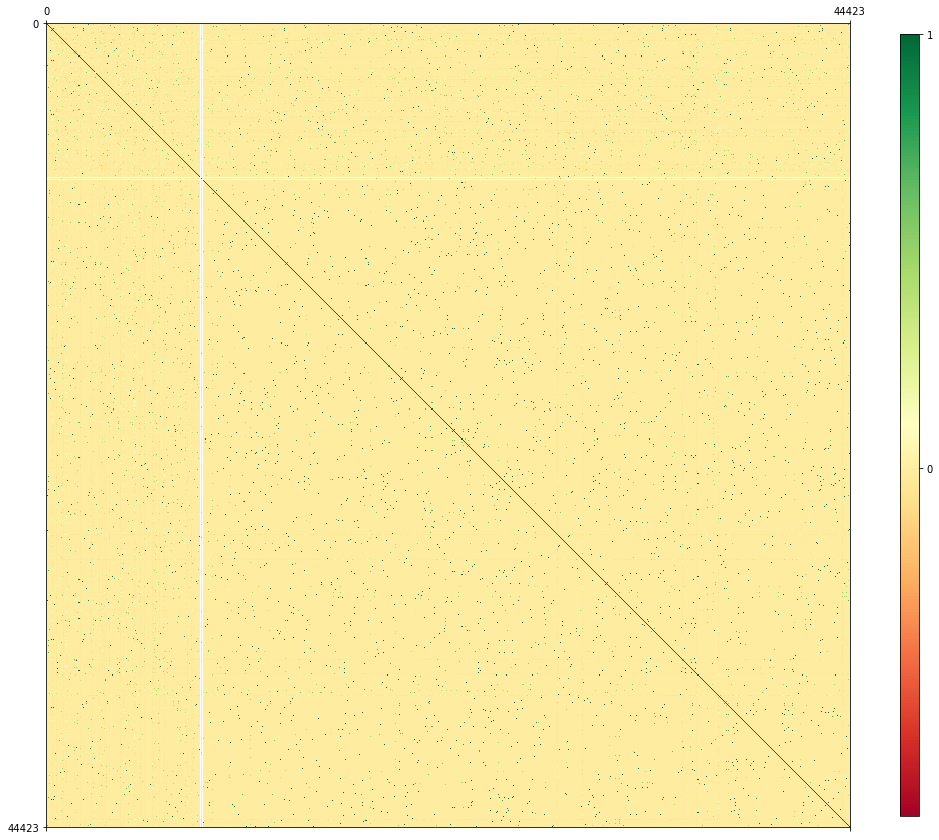

In [53]:
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.hierarchy as sch

def plot_corr(df, size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    # Compute the correlation matrix for the received dataframe
    # Don't use df.corr() as it is is extremely slow
    corr = np.corrcoef(df.T)
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    ax.set_xticks([0, len(corr)])
    ax.set_yticks([0, len(corr)])
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

plot_corr(X_train_df, size=18)

### Crafted features correlation

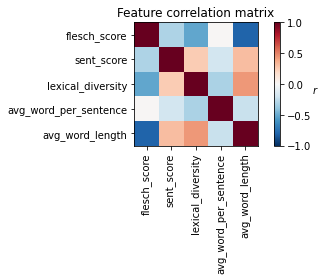

In [54]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
feature_names = colnames_reg.values.tolist()

ax = plt.axes()

target_features = ['flesch_score', 'sent_score', 'lexical_diversity', 'avg_word_per_sentence', 'avg_word_length']
assert [f for f in X_train_df.columns if not f.startswith('punct_') and not f.startswith('word_') and not f.startswith('pos_') and not f.startswith('stop_')] == target_features




im = ax.imshow(np.corrcoef(X_train_df[target_features].T), cmap="RdBu_r", vmin=-1, vmax=1)
ax.set_xticks(list(range(len(target_features))))
ax.set_xticklabels(target_features, rotation=90)
ax.set_yticks(list(range(len(target_features))))
ax.set_yticklabels(list(target_features))

plt.colorbar(im).ax.set_ylabel("$r$", rotation=0)
ax.set_title("Feature correlation matrix")
plt.tight_layout()

### Principal Component Analysis

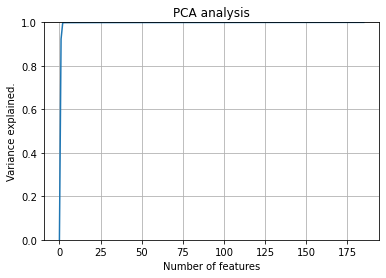

In [55]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


feature_names = colnames_reg.values.tolist()

pca = PCA(n_components=min(len(feature_names), len(X_train_df.index)))
pca.fit_transform(X_train_df.T)

fig, ax = plt.subplots()
ax.set_ylim([0, 1])
var_explained = pca.explained_variance_ratio_.cumsum()
var_explained = np.insert(var_explained, 0, 0)

components = list(range(len(var_explained)))
ax.plot(components, var_explained)


ax.set(xlabel='Number of features', ylabel='Variance explained.',
       title='PCA analysis')
ax.grid()

fig.savefig("pca_analysis.png")
plt.show()

### Agglomerative clustering

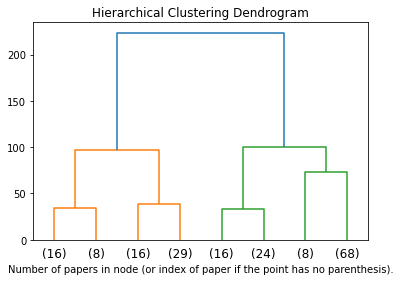

In [56]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


model = AgglomerativeClustering(distance_threshold = 0, n_clusters=None)

model = model.fit(X_train_df)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=2)
plt.xlabel("Number of papers in node (or index of paper if the point has no parenthesis).")
plt.show()